In [1]:
require 'torch'
require 'cutorch'
require 'nn'
require 'nnx'
require 'optim'
require 'image'
require 'dataset-mnist'
require 'pl'
require 'paths'

In [2]:
torch.setnumthreads(4)

In [2]:
classes = {'1','2','3','4','5','6','7','8','9','10'}
geometry = {32,32}

### Define model

In [3]:
torch.setdefaulttensortype("torch.FloatTensor")

In [4]:
require 'cunn'

true	


In [5]:
model = nn.Sequential()
model:add(nn.SpatialConvolutionMM(1, 32, 5, 5))
model:add(nn.Tanh())
model:add(nn.SpatialMaxPooling(3, 3, 3, 3))
-- stage 2 : mean suppresion -> filter bank -> squashing -> max pooling
model:add(nn.SpatialConvolutionMM(32, 64, 5, 5))
model:add(nn.Tanh())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))
-- stage 3 : standard 2-layer MLP:
model:add(nn.Reshape(64*2*2))
model:add(nn.Linear(64*2*2, 200))
model:add(nn.Tanh())
model:add(nn.Linear(200, #classes))
model:add(nn.LogSoftMax())

In [6]:
model = model:cuda()

In [7]:
parameters,gradParameters = model:getParameters()

In [8]:
criterion = nn.ClassNLLCriterion():cuda()

In [9]:
nbTrainingPatches = 60000
nbTestingPatches = 10000

In [10]:
trainData = mnist.loadTrainSet(nbTrainingPatches, geometry)
trainData:normalizeGlobal(mean, std)

<mnist> done	


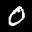

In [25]:
itorch.image(trainData.data[2])

In [26]:
trainData.labels[2]

1	


In [11]:
testData = mnist.loadTestSet(nbTestingPatches, geometry)
testData:normalizeGlobal(mean, std)

<mnist> done	


In [13]:
confusion = optim.ConfusionMatrix(classes)

In [14]:
trainLogger = optim.Logger(paths.concat('train.log'))
testLogger = optim.Logger(paths.concat('test.log'))

In [15]:
batchSize = 100
coefL1 = 0
coefL2 = 0

In [16]:
-- training function
function train(dataset)
   -- epoch tracker
   epoch = epoch or 1

   -- local vars
   local time = sys.clock()

   -- do one epoch
   print('<trainer> on training set:')
   print("<trainer> online epoch # " .. epoch .. ' [batchSize = ' .. batchSize .. ']')
   for t = 1,dataset:size(),batchSize do
      -- create mini batch
      local inputs = torch.CudaTensor(batchSize,1,geometry[1],geometry[2])
      local targets = torch.CudaTensor(batchSize)
      local k = 1
      for i = t,math.min(t+batchSize-1,dataset:size()) do
         -- load new sample
         local sample = dataset[i]
         local input = sample[1]:clone()
         local _,target = sample[2]:clone():max(1)
         target = target:squeeze()
         inputs[k] = input
         targets[k] = target
         k = k + 1
      end

      -- create closure to evaluate f(X) and df/dX
      local feval = function(x)
         -- just in case:
         collectgarbage()

         -- get new parameters
         if x ~= parameters then
            parameters:copy(x)
         end

         -- reset gradients
         gradParameters:zero()

         -- evaluate function for complete mini batch
         local outputs = model:forward(inputs)
         local f = criterion:forward(outputs, targets)

         -- estimate df/dW
         local df_do = criterion:backward(outputs, targets)
         model:backward(inputs, df_do)

         -- penalties (L1 and L2):
         if coefL1 ~= 0 or coefL2 ~= 0 then
            -- locals:
            local norm,sign= torch.norm,torch.sign

            -- Loss:
            f = f + coefL1 * norm(parameters,1)
            f = f + coefL2 * norm(parameters,2)^2/2

            -- Gradients:
            gradParameters:add( sign(parameters):mul(coefL1) + parameters:clone():mul(coefL2) )
         end

         -- update confusion
         for i = 1,batchSize do
            confusion:add(outputs[i], targets[i])
         end

         -- return f and df/dX
         return f,gradParameters
      end

      -- optimize on current mini-batch


     -- Perform SGD step:
     sgdState = sgdState or {
        learningRate = .05,
        momentum = 0,
        learningRateDecay = 5e-7
     }
     optim.sgd(feval, parameters, sgdState)

     -- disp progress
     xlua.progress(t, dataset:size())


   end
   
   -- time taken
   time = sys.clock() - time
   time = time / dataset:size()
   print("<trainer> time to learn 1 sample = " .. (time*1000) .. 'ms')

   -- print confusion matrix
   print(confusion)
   trainLogger:add{['% mean class accuracy (train set)'] = confusion.totalValid * 100}
   confusion:zero()

   -- save/log current net
   local filename = paths.concat('mnist.net')
   os.execute('mkdir -p ' .. sys.dirname(filename))
   if paths.filep(filename) then
      os.execute('mv ' .. filename .. ' ' .. filename .. '.old')
   end
   print('<trainer> saving network to '..filename)
   -- torch.save(filename, model)

   -- next epoch
   epoch = epoch + 1
end

In [17]:

-- test function
function test(dataset)
   -- local vars
   local time = sys.clock()

   -- test over given dataset
   print('<trainer> on testing Set:')
   for t = 1,dataset:size(),batchSize do
      -- disp progress
      xlua.progress(t, dataset:size())

      -- create mini batch
      local inputs = torch.CudaTensor(batchSize,1,geometry[1],geometry[2])
      local targets = torch.CudaTensor(batchSize)
      local k = 1
      for i = t,math.min(t+batchSize-1,dataset:size()) do
         -- load new sample
         local sample = dataset[i]
         local input = sample[1]:clone()
         local _,target = sample[2]:clone():max(1)
         target = target:squeeze()
         inputs[k] = input
         targets[k] = target
         k = k + 1
      end

      -- test samples
      local preds = model:forward(inputs)

      -- confusion:
      for i = 1,batchSize do
         confusion:add(preds[i], targets[i])
      end
   end

   -- timing
   time = sys.clock() - time
   time = time / dataset:size()
   print("<trainer> time to test 1 sample = " .. (time*1000) .. 'ms')

   -- print confusion matrix
   print(confusion)
   testLogger:add{['% mean class accuracy (test set)'] = confusion.totalValid * 100}
   confusion:zero()
end

----------------------------------------------------------------------


In [ ]:
while true do
   -- train/test
   train(trainData)
   test(testData)

   -- plot errors

      trainLogger:style{['% mean class accuracy (train set)'] = '-'}
      testLogger:style{['% mean class accuracy (test set)'] = '-'}
      trainLogger:plot()
      testLogger:plot()
end

<trainer> on training set:	


<trainer> online epoch # 2 [batchSize = 100]	


Progress: 18701 / 60000	


Progress: 47401 / 60000	


<trainer> time to learn 1 sample = 0.52418931722641ms	
ConfusionMatrix:
[[    5803       2      17       1       9      14      34       2      30      11]   97.974% 	[class: 1]
 [       1    6638      42      17       7       4       6      11      10       6]   98.457% 	[class: 2]
 [      22      23    5699      52      22       3      20      72      35      10]   95.653% 	[class: 3]
 [       7       3      79    5882       0      53       3      34      46      24]   95.939% 	[class: 4]
 [       9      10      13       1    5633       0      48       9      11     108]   96.422% 	[class: 5]
 [      17       8      10      49       8    5232      32       2      40      23]   96.514% 	[class: 6]
 [      27      11       5       0      21      38    5795       0      21       0]   97.922% 	[class: 7]
 [      12      15      60       8      28       3       0    6049       4      86]   96.552% 	[class: 8]
 [      14      18      19      53      18      33      29       4    5617      

<trainer> saving network to /home/saurabh/Desktop/COGS 260/Project 2/torch tutorial/Assignment 2/mnist.net	
<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.23723428249359ms	
ConfusionMatrix:
[[     975       0       0       0       0       1       1       1       2       0]   99.490% 	[class: 1]
 [       0    1127       2       2       0       2       1       0       1       0]   99.295% 	[class: 2]
 [       8       1     990       8       2       0       1      15       5       2]   95.930% 	[class: 3]
 [       0       1       2     988       0       7       0       6       3       3]   97.822% 	[class: 4]
 [       1       0       1       0     953       0       7       1       2      17]   97.047% 	[class: 5]
 [       2       0       0       7       0     880       1       1       1       0]   98.655% 	[class: 6]
 [       9       3       1       0       7      13     921       0       4       0]   96.138% 	[class: 7]
 [       1       5      11       3       0       0       0     999       1       8]   97.179% 	[class: 8]
 [       5       0       2       5       3       4       2       3     943       

<trainer> on training set:	
<trainer> online epoch # 3 [batchSize = 100]	


Progress: 11301 / 60000	


Progress: 40001 / 60000	


<trainer> time to learn 1 sample = 0.52445978323619ms	


ConfusionMatrix:
[[    5841       3      11       1       3       9      27       0      19       9]   98.616% 	[class: 1]
 [       1    6663      33      11       5       2       4      13       6       4]   98.828% 	[class: 2]
 [      12      19    5785      38      12       1       6      56      21       8]   97.096% 	[class: 3]
 [       5       3      52    5968       0      36       1      24      23      19]   97.341% 	[class: 4]
 [       7      10       7       0    5708       0      29       9       7      65]   97.706% 	[class: 5]
 [      10       5       3      26       3    5305      26       2      28      13]   97.860% 	[class: 6]
 [      20       6       2       0      12      26    5838       0      14       0]   98.648% 	[class: 7]
 [       7      15      40       7      19       2       0    6126       1      48]   97.781% 	[class: 8]
 [      12      13      12      38      15      19      26       4    5674      38]   96.975% 	[class: 9]
 [      22      10       3   

<trainer> saving network to /home/saurabh/Desktop/COGS 260/Project 2/torch tutorial/Assignment 2/mnist.net	
<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.23836920261383ms	
ConfusionMatrix:
[[     974       0       2       0       0       1       1       1       1       0]   99.388% 	[class: 1]
 [       0    1128       2       3       0       2       0       0       0       0]   99.383% 	[class: 2]
 [       7       1    1002       6       1       0       1      11       2       1]   97.093% 	[class: 3]
 [       0       0       2     995       0       6       0       5       1       1]   98.515% 	[class: 4]
 [       1       0       1       0     961       0       6       1       1      11]   97.862% 	[class: 5]
 [       1       0       0       4       0     884       1       1       1       0]   99.103% 	[class: 6]
 [      11       3       1       1       3      15     922       0       2       0]   96.242% 	[class: 7]
 [       0       4       8       2       0       0       0    1009       0       5]   98.152% 	[class: 8]
 [       3       0       2       4       3       4       2       2     948       

      6 : 6
      7 : 7
      8 : 8
      9 : 9
      10 : 10
    }
  _prediction : FloatTensor - size: 10
  _pred_idx : LongTensor - size: 1
  nclasses : 10
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 10
  totalValid : 0.9806
}


<trainer> on training set:	
<trainer> online epoch # 4 [batchSize = 100]	


Progress: 3901 / 60000	


Progress: 32601 / 60000	


<trainer> time to learn 1 sample = 0.52374596993128ms	
ConfusionMatrix:
[[    5858       2      10       1       2       8      22       0      13       7]   98.903% 	[class: 1]
 [       1    6675      29       5       4       2       4      13       5       4]   99.006% 	[class: 2]
 [      10      12    5834      22       7       1       3      47      16       6]   97.919% 	[class: 3]
 [       3       1      35    6015       0      30       1      16      16      14]   98.108% 	[class: 4]
 [       4       8       7       0    5741       0      20       7       7      48]   98.271% 	[class: 5]
 [       7       5       3      15       2    5329      26       3      21      10]   98.303% 	[class: 6]
 [      17       5       1       0       8      19    5858       0      10       0]   98.986% 	[class: 7]
 [       7      15      36       4      15       2       0    6158       2      26]   98.292% 	[class: 8]
 [       7      11      11      23      13      11      21       3    5722      

<trainer> saving network to /home/saurabh/Desktop/COGS 260/Project 2/torch tutorial/Assignment 2/mnist.net	
<trainer> on testing Set:	


Progress: 3001 / 10000	


<trainer> time to test 1 sample = 0.2379086971283ms	


ConfusionMatrix:
[[     974       0       2       0       0       1       1       1       1       0]   99.388% 	[class: 1]
 [       0    1128       2       3       0       2       0       0       0       0]   99.383% 	[class: 2]
 [       5       1    1011       5       1       0       1       7       0       1]   97.965% 	[class: 3]
 [       0       0       2     998       0       4       0       4       1       1]   98.812% 	[class: 4]
 [       1       0       0       0     966       0       4       1       1       9]   98.371% 	[class: 5]
 [       1       0       0       4       0     885       1       1       0       0]   99.215% 	[class: 6]
 [       9       3       1       1       2      14     926       0       2       0]   96.660% 	[class: 7]
 [       0       3       6       1       0       0       0    1014       0       4]   98.638% 	[class: 8]
 [       1       0       2       3       3       3       2       1     954       5]   97.947% 	[class: 9]
 [       5       3       1   

<trainer> on training set:	
<trainer> online epoch # 5 [batchSize = 100]	


Progress: 25201 / 60000	


Progress: 54001 / 60000	


<trainer> time to learn 1 sample = 0.52227673133214ms	


ConfusionMatrix:
[[    5871       1       8       1       2       6      17       0      11       6]   99.122% 	[class: 1]
 [       1    6684      23       2       2       2       4      16       5       3]   99.140% 	[class: 2]
 [       5      12    5865      13       4       0       3      40      13       3]   98.439% 	[class: 3]
 [       2       1      25    6036       0      28       1      13      13      12]   98.450% 	[class: 4]
 [       4       5       6       0    5769       0      13       6       5      34]   98.750% 	[class: 5]
 [       4       3       3      10       2    5352      20       3      16       8]   98.727% 	[class: 6]
 [      16       5       2       0       8      16    5862       0       9       0]   99.054% 	[class: 7]
 [       6      15      27       2      10       2       0    6180       2      21]   98.643% 	[class: 8]
 [       5       9      12      17      11       9      15       3    5746      24]   98.205% 	[class: 9]
 [      15       4       2   

<trainer> saving network to /home/saurabh/Desktop/COGS 260/Project 2/torch tutorial/Assignment 2/mnist.net	
<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.23735589981079ms	
ConfusionMatrix:
[[     974       0       2       0       0       1       0       1       2       0]   99.388% 	[class: 1]
 [       0    1129       2       2       0       2       0       0       0       0]   99.471% 	[class: 2]
 [       4       1    1013       3       1       0       1       8       0       1]   98.159% 	[class: 3]
 [       0       0       2    1000       0       3       0       4       1       0]   99.010% 	[class: 4]
 [       1       0       0       0     971       0       4       0       1       5]   98.880% 	[class: 5]
 [       1       0       0       4       0     885       1       1       0       0]   99.215% 	[class: 6]
 [       8       3       0       1       2      11     931       0       2       0]   97.182% 	[class: 7]
 [       0       3       5       1       0       0       0    1015       0       4]   98.735% 	[class: 8]
 [       1       0       2       4       3       4       1       1     953       

      4 : 4
      5 : 5
      6 : 6
      7 : 7
      8 : 8
      9 : 9
      10 : 10
    }
  _prediction : FloatTensor - size: 10
  _pred_idx : LongTensor - size: 1
  nclasses : 10
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 10
  totalValid : 0.9855
}


<trainer> on training set:	
<trainer> online epoch # 6 [batchSize = 100]	


Progress: 18001 / 60000	


Progress: 46801 / 60000	


<trainer> time to learn 1 sample = 0.52205413182576ms	
ConfusionMatrix:
[[    5882       1       6       1       2       2      14       0       9       6]   99.308% 	[class: 1]
 [       1    6688      22       1       2       1       5      15       5       2]   99.199% 	[class: 2]
 [       4      10    5886      11       2       0       3      35       4       3]   98.792% 	[class: 3]
 [       2       1      20    6060       0      22       1       8       9       8]   98.842% 	[class: 4]
 [       4       4       5       0    5785       0      11       4       4      25]   99.024% 	[class: 5]
 [       3       2       3      10       2    5362      18       3      10       8]   98.912% 	[class: 6]
 [      12       4       2       0       7      14    5872       0       7       0]   99.223% 	[class: 7]
 [       4      14      20       2       7       1       0    6199       2      16]   98.947% 	[class: 8]
 [       4       7      10      13      11       6      12       3    5764      

 averageUnionValid : 0.97835037112236
  _targ_idx : LongTensor - empty
  averageValid : 0.98904400467873
  classes : 
    {
      1 : 1
      2 : 2
      3 : 3
      4 : 4
      5 : 5
      6 : 6
      7 : 7
      8 : 8
      9 : 9
      10 : 10
    }
  _prediction : FloatTensor - size: 10
  _pred_idx : LongTensor - size: 1
  nclasses : 10
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 10
  totalValid : 0.98908333333333
}


<trainer> saving network to /home/saurabh/Desktop/COGS 260/Project 2/torch tutorial/Assignment 2/mnist.net	
<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.23767740726471ms	
ConfusionMatrix:
[[     975       0       2       0       0       1       0       1       1       0]   99.490% 	[class: 1]
 [       0    1129       1       2       0       3       0       0       0       0]   99.471% 	[class: 2]
 [       4       1    1016       2       1       0       0       7       0       1]   98.450% 	[class: 3]
 [       0       0       3    1000       0       3       0       3       1       0]   99.010% 	[class: 4]
 [       1       0       0       0     970       0       4       1       1       5]   98.778% 	[class: 5]
 [       1       0       0       4       0     885       1       1       0       0]   99.215% 	[class: 6]
 [       8       3       0       1       2      10     932       0       2       0]   97.286% 	[class: 7]
 [       0       3       5       1       0       0       0    1016       0       3]   98.833% 	[class: 8]
 [       1       0       2       4       3       4       1       1     952       

<trainer> on training set:	
<trainer> online epoch # 7 [batchSize = 100]	


Progress: 10801 / 60000	


Progress: 39501 / 60000	


<trainer> time to learn 1 sample = 0.52292669614156ms	
ConfusionMatrix:
[[    5888       1       6       1       2       2      13       0       7       3]   99.409% 	[class: 1]
 [       1    6700      14       1       2       1       3      14       4       2]   99.377% 	[class: 2]
 [       4       8    5898       9       2       0       2      28       4       3]   98.993% 	[class: 3]
 [       2       0      17    6070       0      19       1       8       6       8]   99.005% 	[class: 4]
 [       4       3       4       0    5796       0       8       3       3      21]   99.213% 	[class: 5]
 [       3       2       2       7       0    5369      17       5      10       6]   99.041% 	[class: 6]
 [       9       4       2       0       5       8    5881       0       9       0]   99.375% 	[class: 7]
 [       3      12      18       1       7       1       0    6208       2      13]   99.090% 	[class: 8]
 [       3       8       8      11       9       5      10       2    5777      

<trainer> saving network to /home/saurabh/Desktop/COGS 260/Project 2/torch tutorial/Assignment 2/mnist.net	
<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.2367760181427ms	
ConfusionMatrix:
[[     974       0       2       0       0       1       1       1       1       0]   99.388% 	[class: 1]
 [       0    1130       1       1       0       3       0       0       0       0]   99.559% 	[class: 2]
 [       3       1    1020       0       1       0       0       6       0       1]   98.837% 	[class: 3]
 [       0       0       3    1000       0       3       0       3       1       0]   99.010% 	[class: 4]
 [       0       0       0       0     971       0       3       1       1       6]   98.880% 	[class: 5]
 [       1       0       0       4       0     885       1       1       0       0]   99.215% 	[class: 6]
 [       8       3       0       1       2       9     934       0       1       0]   97.495% 	[class: 7]
 [       0       3       4       1       0       0       0    1018       0       2]   99.027% 	[class: 8]
 [       2       0       2       4       3       4       1       1     951       6

    1 : 1
      2 : 2
      3 : 3
      4 : 4
      5 : 5
      6 : 6
      7 : 7
      8 : 8
      9 : 9
      10 : 10
    }
  _prediction : FloatTensor - size: 10
  _pred_idx : LongTensor - size: 1
  nclasses : 10
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 10
  totalValid : 0.9874
}


<trainer> on training set:	
<trainer> online epoch # 8 [batchSize = 100]	


Progress: 3501 / 60000	


Progress: 32301 / 60000	


<trainer> time to learn 1 sample = 0.52244659662247ms	
ConfusionMatrix:
[[    5898       1       3       0       1       1      11       0       5       3]   99.578% 	[class: 1]
 [       1    6704      12       1       2       1       3      12       4       2]   99.436% 	[class: 2]
 [       3       7    5912       6       2       0       2      21       2       3]   99.228% 	[class: 3]
 [       2       0      15    6074       0      17       1       8       6       8]   99.070% 	[class: 4]
 [       4       3       4       0    5800       0       7       2       3      19]   99.281% 	[class: 5]
 [       3       2       1       7       0    5377      16       5       6       4]   99.188% 	[class: 6]
 [       8       4       2       0       4       6    5886       0       8       0]   99.459% 	[class: 7]
 [       3      11      16       1       5       1       0    6214       2      12]   99.186% 	[class: 8]
 [       3       7       6       9       8       6       7       1    5789      

<trainer> saving network to /home/saurabh/Desktop/COGS 260/Project 2/torch tutorial/Assignment 2/mnist.net	
<trainer> on testing Set:	


Progress: 2501 / 10000	


<trainer> time to test 1 sample = 0.23708388805389ms	
ConfusionMatrix:
[[     975       0       2       0       0       0       1       1       1       0]   99.490% 	[class: 1]
 [       0    1131       1       1       0       2       0       0       0       0]   99.648% 	[class: 2]
 [       2       2    1021       0       1       0       0       5       0       1]   98.934% 	[class: 3]
 [       0       0       4     998       0       4       0       3       1       0]   98.812% 	[class: 4]
 [       0       1       0       0     972       0       2       1       1       5]   98.982% 	[class: 5]
 [       1       0       0       4       0     885       1       1       0       0]   99.215% 	[class: 6]
 [       8       3       0       1       2       8     935       0       1       0]   97.599% 	[class: 7]
 [       0       3       4       0       0       0       0    1018       0       3]   99.027% 	[class: 8]
 [       2       0       2       4       3       4       1       1     952       

<trainer> on training set:	
<trainer> online epoch # 9 [batchSize = 100]	


Progress: 25001 / 60000	


Progress: 53701 / 60000	


<trainer> time to learn 1 sample = 0.52251796722412ms	


ConfusionMatrix:
[[    5902       1       2       0       1       0      10       0       4       3]   99.645% 	[class: 1]
 [       1    6710      10       0       1       1       2      12       3       2]   99.525% 	[class: 2]
 [       2       7    5919       4       2       0       2      17       2       3]   99.345% 	[class: 3]
 [       1       0      11    6088       0      14       1       3       6       7]   99.299% 	[class: 4]
 [       4       3       4       0    5803       0       6       2       2      18]   99.332% 	[class: 5]
 [       2       2       1       6       0    5385      13       2       6       4]   99.336% 	[class: 6]
 [       8       3       2       0       4       5    5888       0       8       0]   99.493% 	[class: 7]
 [       1      10      16       0       5       1       0    6221       2       9]   99.298% 	[class: 8]
 [       3       4       5       7       8       5       6       1    5799      13]   99.111% 	[class: 9]
 [       8       3       0   

<trainer> saving network to /home/saurabh/Desktop/COGS 260/Project 2/torch tutorial/Assignment 2/mnist.net	
<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.23712458610535ms	


ConfusionMatrix:
[[     975       0       2       0       0       0       1       1       1       0]   99.490% 	[class: 1]
 [       0    1131       1       1       0       2       0       0       0       0]   99.648% 	[class: 2]
 [       2       2    1022       0       1       0       0       5       0       0]   99.031% 	[class: 3]
 [       0       0       4     999       0       4       0       2       1       0]   98.911% 	[class: 4]
 [       0       1       0       0     971       0       2       1       1       6]   98.880% 	[class: 5]
 [       1       0       0       4       0     885       1       1       0       0]   99.215% 	[class: 6]
 [       8       3       0       1       1       8     936       0       1       0]   97.704% 	[class: 7]
 [       0       3       4       0       0       0       0    1018       0       3]   99.027% 	[class: 8]
 [       2       0       2       4       3       4       1       1     952       5]   97.741% 	[class: 9]
 [       1       0       0   

<trainer> on training set:	
<trainer> online epoch # 10 [batchSize = 100]	


Progress: 17701 / 60000	


Progress: 46401 / 60000	


<trainer> time to learn 1 sample = 0.52272956768672ms	
ConfusionMatrix:
[[    5907       1       1       0       1       0       7       0       3       3]   99.730% 	[class: 1]
 [       1    6712       9       0       1       1       2      13       2       1]   99.555% 	[class: 2]
 [       2       6    5923       3       2       0       1      16       2       3]   99.413% 	[class: 3]
 [       1       0      10    6094       0      13       1       2       4       6]   99.397% 	[class: 4]
 [       3       3       3       0    5809       0       4       2       2      16]   99.435% 	[class: 5]
 [       2       2       0       5       0    5392      12       1       4       3]   99.465% 	[class: 6]
 [       7       3       2       0       4       3    5893       0       6       0]   99.578% 	[class: 7]
 [       1      10      16       0       5       0       0    6224       2       7]   99.346% 	[class: 8]
 [       3       4       4       7       5       5       4       0    5808      

  _pred_idx : LongTensor - size: 1
  nclasses : 10
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 10
  totalValid : 0.99438333333333
}


<trainer> saving network to /home/saurabh/Desktop/COGS 260/Project 2/torch tutorial/Assignment 2/mnist.net	
<trainer> on testing Set:	


<trainer> time to test 1 sample = 0.23722949028015ms	
ConfusionMatrix:
[[     975       0       2       0       0       0       1       1       1       0]   99.490% 	[class: 1]
 [       0    1131       1       1       0       2       0       0       0       0]   99.648% 	[class: 2]
 [       2       2    1022       0       1       0       0       5       0       0]   99.031% 	[class: 3]
 [       0       0       4     999       0       4       0       2       1       0]   98.911% 	[class: 4]
 [       0       1       0       0     972       0       2       1       1       5]   98.982% 	[class: 5]
 [       1       0       0       4       0     885       1       1       0       0]   99.215% 	[class: 6]
 [       8       3       0       1       1       7     937       0       1       0]   97.808% 	[class: 7]
 [       0       3       3       0       0       0       0    1019       0       3]   99.125% 	[class: 8]
 [       1       0       2       4       2       3       1       1     955       

 10 : 10
    }
  _prediction : FloatTensor - size: 10
  _pred_idx : LongTensor - size: 1
  nclasses : 10
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 10
  totalValid : 0.9888
}


<trainer> on training set:	
<trainer> online epoch # 11 [batchSize = 100]	


Progress: 10401 / 60000	
